<a href="https://colab.research.google.com/github/danielkennedy1/CS6524_Computer_Vision/blob/main/CelebA_Conv_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import warnings
import kagglehub
from pathlib import Path
from google.colab import drive
from datetime import datetime


warnings.filterwarnings('ignore')

In [2]:
FOLDER_NUMBER = 4 # Change to put checkpoints into different folders
SAMPLE_COUNT = 50_000

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
warnings.filterwarnings('ignore')

Using device: cuda


In [5]:
dataset_path = kagglehub.dataset_download(
    "kushsheth/face-vae",
)

Using Colab cache for faster access to the 'face-vae' dataset.


In [6]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))][:SAMPLE_COUNT]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [7]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # [0, 1] -> [-1, 1]
])

In [8]:
dataset = CelebADataset(f'{dataset_path}/img_align_celeba/img_align_celeba', transform=transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)

print(f"Dataset size: {len(dataset)}")
print(f"No. of Batches: {len(dataloader)}")
print(f"Sample shape: {dataset[0].shape}")

Dataset size: 50000
No. of Batches: 196
Sample shape: torch.Size([3, 256, 256])


In [9]:
def plot_image(image):
    '''
    Takes in an image and shows it using matplotlib
    this is used to visualize the data and also the outputs of our network
    '''
    image = (image + 1) / 2 # [-1, 1] -> [0, 1]
    plt.figure()
    plt.imshow(image.cpu().permute(1, 2, 0).numpy())
    plt.grid('off')
    plt.axis('off')
    plt.show()

VERY IMPORTANT: This should be Jim from The Office

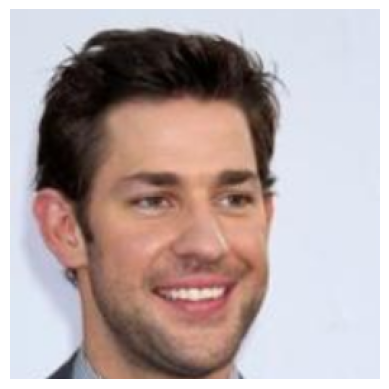

In [10]:
plot_image(dataset[0])

In [11]:
def conv_output_size(input_size, kernel_size, stride=1, padding=0):
    return (input_size + 2 * padding - kernel_size) // stride + 1

In [12]:
def convtranspose_output_size(input_size, kernel_size, stride=1, padding=0, output_padding=0):
    return (input_size - 1) * stride - 2 * padding + kernel_size + output_padding

In [13]:
conv_output_size(32, 4, 2, 1)

16

In [14]:
convtranspose_output_size(128, 6, 2, 2)

256

In [15]:
# --- Convolutional VAE ---
class ConvVAE(nn.Module):
    def __init__(self, latent_dimension: int, image_channels: int):
        super().__init__()
        self.latent_dim = latent_dimension
        self.image_channels = image_channels
        self.W_lat = 16
        self.H_lat = 16

        # Encoder: 3x256x256 -conv> 256x126x126 -conv> 256x32x32 -conv> 512x16x16 -flatten> 131072 -fcx2> latent_dim (mu, logvar)
        self.enc = nn.Sequential(
            nn.Conv2d(image_channels, 256, kernel_size=8, stride=2, padding=1),  # 126x126
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=8, stride=4, padding=4),  # 32x32
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(True),
        )
        self.enc_fc_mu = nn.Linear(self.latent_dim * self.W_lat * self.H_lat, self.latent_dim)
        self.enc_fc_logvar = nn.Linear(self.latent_dim * self.W_lat * self.H_lat, self.latent_dim)

        # Decoder: latent_dim (z) -fc> 131072 -reshape(in decode)> 512x16x16 -> 256x32x32 -> 256x128x128 -> 3x256x256
        self.dec_fc = nn.Linear(self.latent_dim, self.latent_dim * 16 * 16)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, 256, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=4, padding=2),  # 128x128
            nn.ReLU(True),
            nn.ConvTranspose2d(256, image_channels, kernel_size=6, stride=2, padding=2),  # 256x256
            nn.Tanh(),  # output in [-1,1]
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu = self.enc_fc_mu(h)
        logvar = self.enc_fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z_vec):
        h = self.dec_fc(z_vec)
        h = h.view(z_vec.size(0), self.latent_dim, self.W_lat, self.H_lat)
        x_recon = self.dec(h)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z_vec = self.reparameterize(mu, logvar)
        x_recon = self.decode(z_vec)
        return x_recon, mu, logvar

def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl, recon_loss, kl

vae = ConvVAE(latent_dimension=512, image_channels=3).to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

print("VAE parameters (M):", sum(p.numel() for p in vae.parameters())/1e6)
print(vae)


VAE parameters (M): 214.119939
ConvVAE(
  (enc): Sequential(
    (0): Conv2d(3, 256, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(8, 8), stride=(4, 4), padding=(4, 4))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (enc_fc_mu): Linear(in_features=131072, out_features=512, bias=True)
  (enc_fc_logvar): Linear(in_features=131072, out_features=512, bias=True)
  (dec_fc): Linear(in_features=512, out_features=131072, bias=True)
  (dec): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 256, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(256, 3, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (5): Tanh()
  )
)


In [16]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl, recon_loss, kl

In [17]:
drive.mount('/content/drive')

checkpoint_dir = Path(f'/content/drive/MyDrive/CS6524/VAE_checkpoints_{FOLDER_NUMBER}')
checkpoint_dir.mkdir(exist_ok=True, parents=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)

def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['loss']

In [19]:
#load_checkpoint(vae, vae_opt, checkpoint_dir / 'latest.pt')

In [20]:
num_vae_epochs = 1

sum_loss_history = []
recon_loss_history = []
kl_loss_history = []

vae.train()
for epoch in range(num_vae_epochs):
    pbar = tqdm(dataloader, desc=f"VAE Epoch {epoch+1}/{num_vae_epochs}")

    total_sum_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.00
    total_kl_loss = 0.0

    for imgs in pbar:
        imgs = imgs.to(device)
        x_recon, mu, logvar = vae(imgs)
        loss, r_loss, kl = vae_loss(x_recon, imgs, mu, logvar)

        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()

        total_sum_loss += loss.item() * imgs.size(0)
        total_recon_loss += r_loss.item() * imgs.size(0)
        total_kl_loss += kl.item() * imgs.size(0)
        pbar.set_postfix({"loss": loss.item(), "recon": r_loss.item(), "kl": kl.item()})

    #save_checkpoint(vae, vae_opt, epoch, loss, checkpoint_dir / 'latest.pt')

    sum_loss_history.append(total_sum_loss / len(dataset))
    recon_loss_history.append(total_recon_loss / len(dataset))
    kl_loss_history.append(total_kl_loss / len(dataset))

    print(f"Epoch {epoch+1}: avg loss = {total_sum_loss/len(dataset):.4f}")


VAE Epoch 1/1: 100%|██████████| 196/196 [04:13<00:00,  1.29s/it, loss=6.44e+4, recon=6.44e+4, kl=57.8]

Epoch 1: avg loss = 70816.5703


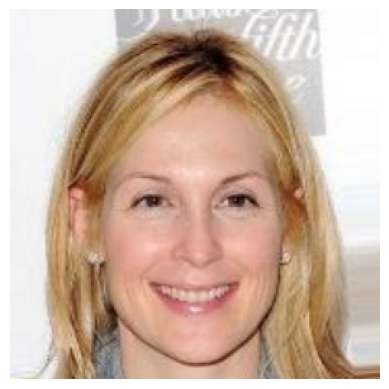

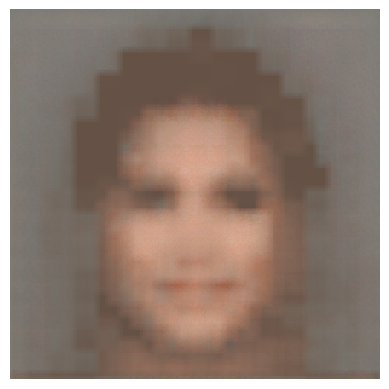

In [21]:
vae.eval()

imgs = next(iter(dataloader))
imgs = imgs.to(device)[:8]
with torch.no_grad():
    recon, _, _ = vae(imgs)

plot_image(imgs[0])
plot_image(recon[0])

In [22]:
sum_loss_history

[70816.57031]

In [23]:
recon_loss_history

[66938.28685375]

In [24]:
kl_loss_history

[3878.2833455076598]